In [1]:
# import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


**Disclaimer**

More "theoretical" explanation can be found in the report. 

In [2]:
df = pd.read_csv('/kaggle/input/loan-approval-classification-data/loan_data.csv')
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


**Mini-conclusion**


The dataset has 45000 rows and 14 columns: 

| **Feature Name**                 | **Description**                                            | **Data Type**     |
|----------------------------------|------------------------------------------------------------|-------------------|
| `person_age`                     | Age of the person                                          | Float             |
| `person_gender`                  | Gender of the person                                       | Categorical       |
| `person_education`               | Highest education level                                    | Categorical       |
| `person_income`                  | Annual income                                              | Float             |
| `person_emp_exp`                 | Years of employment experience                             | Integer           |
| `person_home_ownership`          | Home ownership status (e.g., rent, own, mortgage)         | Categorical       |
| `loan_amnt`                      | Loan amount requested                                      | Float             |
| `loan_intent`                    | Purpose of the loan                                        | Categorical       |
| `loan_int_rate`                  | Loan interest rate                                         | Float             |
| `loan_percent_income`            | Loan amount as a percentage of annual income              | Float             |
| `cb_person_cred_hist_length`     | Length of credit history in years                         | Float             |
| `credit_score`                   | Credit score of the person                                | Integer           |
| `previous_loan_defaults_on_file` | Indicator of previous loan defaults                       | Categof the dataset.*


# EDA

In [3]:
df.isna().sum() # let's notice that there's no nan values

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [4]:
# split features into numeric and categorical
numeric_features = df.select_dtypes(['int64', 'float64']).columns
categorical_features = df.select_dtypes('object').columns

In [5]:
df['loan_status'].value_counts() # 1 = approved; 0 = rejected
# dataset is highly imbalanced

loan_status
0    35000
1    10000
Name: count, dtype: int64

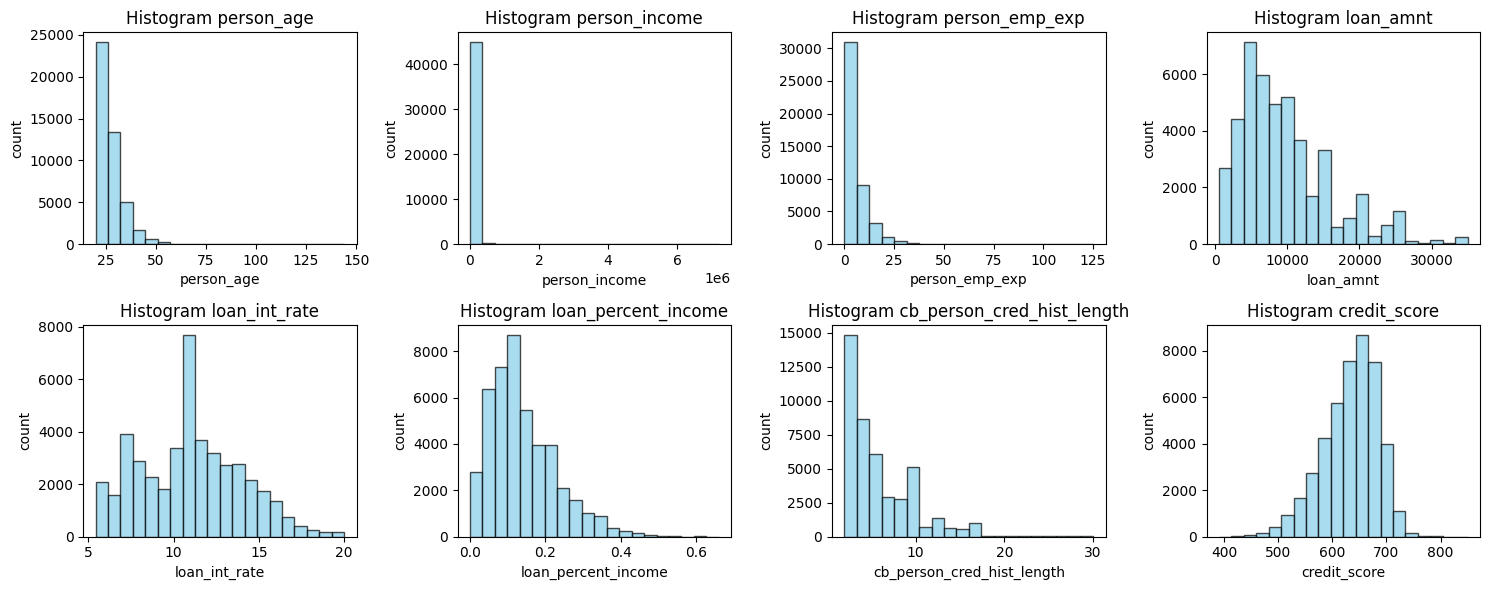

In [6]:
# Let's have a look at the distributions
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    ax.hist(df[numeric_features[i]], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram {numeric_features[i]}')
    ax.set_xlabel(numeric_features[i])
    ax.set_ylabel('count')
fig.tight_layout()
plt.show()

In [7]:
# as we've noticed, some features have long tails. For example, there are people who are older than 100 years old. They probably won't apply for a loan, so I think it's a mistake. 
df[df['person_age'] > 80] # probably mistake

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
81,144.0,male,Bachelor,300616.0,125,RENT,4800.0,VENTURE,13.57,0.02,3.0,789,No,0
183,144.0,male,Associate,241424.0,121,MORTGAGE,6000.0,EDUCATION,11.86,0.02,2.0,807,No,0
575,123.0,female,High School,97140.0,101,RENT,20400.0,EDUCATION,10.25,0.21,3.0,805,Yes,0
747,123.0,male,Bachelor,94723.0,100,RENT,20000.0,VENTURE,11.01,0.21,4.0,714,Yes,0
32297,144.0,female,Associate,7200766.0,124,MORTGAGE,5000.0,PERSONAL,12.73,0.00,25.0,850,No,0
32416,94.0,male,High School,29738.0,76,RENT,6500.0,MEDICAL,11.01,0.22,27.0,773,No,0
32506,84.0,male,High School,114705.0,61,MORTGAGE,10000.0,PERSONAL,7.51,0.09,24.0,784,Yes,0
37930,116.0,male,Bachelor,5545545.0,93,MORTGAGE,3823.0,VENTURE,12.15,0.00,24.0,708,No,0
38113,109.0,male,High School,5556399.0,85,MORTGAGE,6195.0,VENTURE,12.58,0.00,22.0,792,No,0


In [8]:
percentile_90 = df['person_age'].quantile(0.9)
# Filter out rows where 'person_age' is greater than the 90th percentile
df = df[df['person_age'] <= percentile_90]
# Transform using np.log because their tails are way too long
df['person_age'] = np.log(df['person_age'])
df['person_income'] = np.log(df['person_income'])
df['person_emp_exp'] = np.log(df['person_emp_exp'])
df['cb_person_cred_hist_length'] = np.log(df['cb_person_cred_hist_length'])
df = df.replace(-np.inf, 0) # np.log(0) is -np.inf, we need to replace it with 0 manually
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,3.091042,female,Master,11.183699,0.000000,RENT,35000.0,PERSONAL,16.02,0.49,1.098612,561,No,1
1,3.044522,female,High School,9.415890,0.000000,OWN,1000.0,EDUCATION,11.14,0.08,0.693147,504,Yes,0
2,3.218876,female,High School,9.428512,1.098612,MORTGAGE,5500.0,MEDICAL,12.87,0.44,1.098612,635,No,1
3,3.135494,female,Bachelor,11.286690,0.000000,RENT,35000.0,MEDICAL,15.23,0.44,0.693147,675,No,1
4,3.178054,male,Master,11.099453,0.000000,RENT,35000.0,MEDICAL,14.27,0.53,1.386294,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,3.178054,female,Associate,10.371113,0.693147,RENT,12229.0,MEDICAL,10.70,0.38,1.386294,678,No,1
44995,3.295837,male,Associate,10.778352,1.791759,RENT,15000.0,MEDICAL,15.66,0.31,1.098612,645,No,1
44997,3.496508,male,Associate,10.949788,1.945910,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,2.302585,668,No,1
44998,3.367296,male,Bachelor,10.409220,1.386294,RENT,12000.0,EDUCATION,13.23,0.36,1.791759,604,No,1


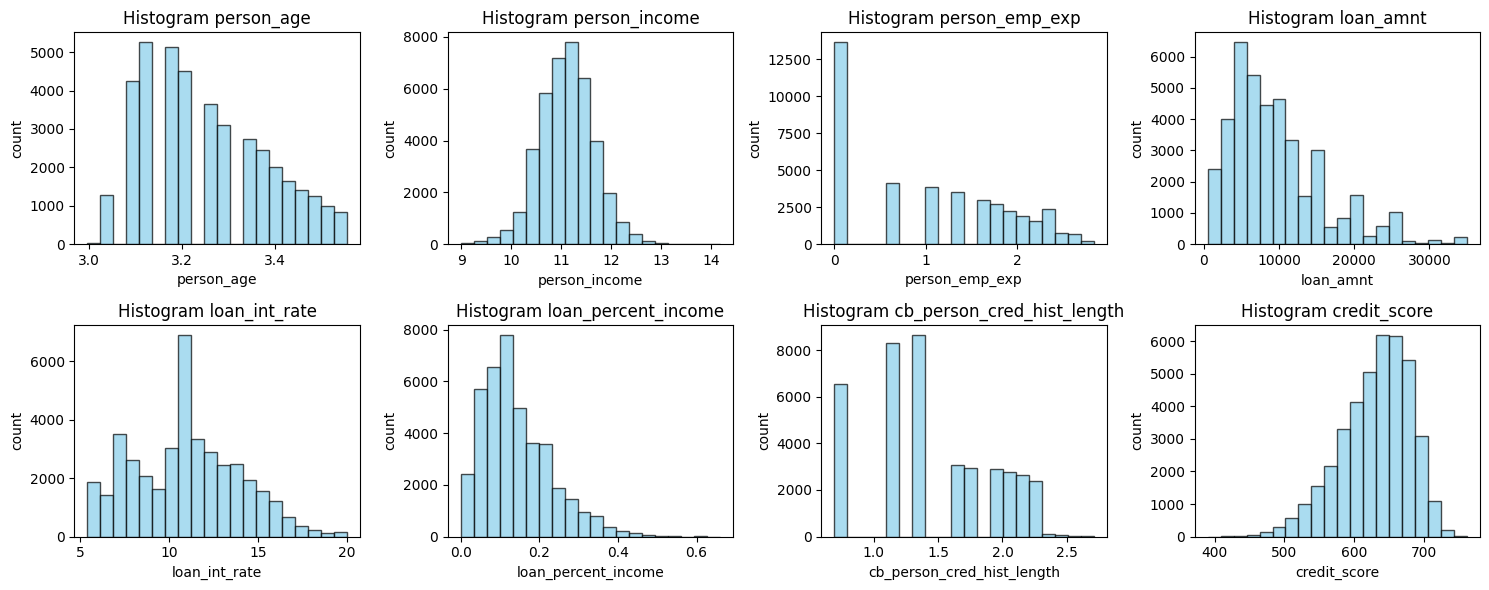

In [9]:
# Let's look at the distribution again
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    ax.hist(df[numeric_features[i]], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram {numeric_features[i]}')
    ax.set_xlabel(numeric_features[i])
    ax.set_ylabel('count')
fig.tight_layout()
plt.show()

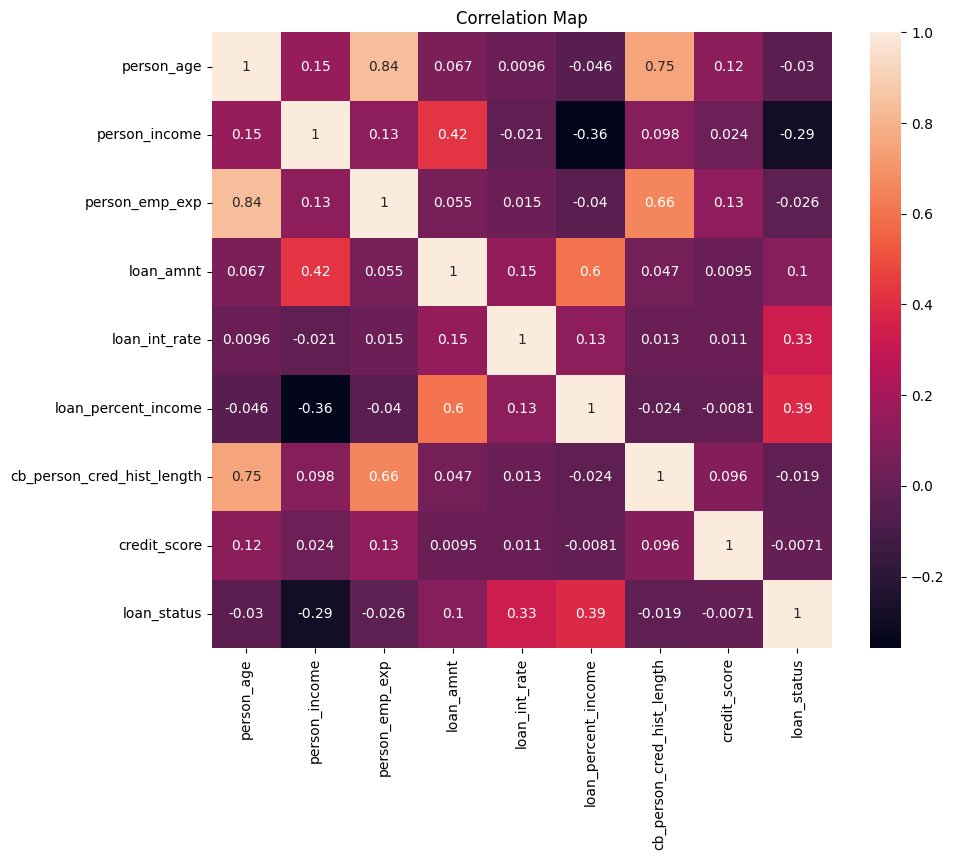

In [10]:
# Let's look at the correlation map. We can see a person's income doesn't correlate with our target. We can notice that some targets are less correlated with our target
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features].corr(), annot=True)
plt.title('Correlation Map')
plt.show()

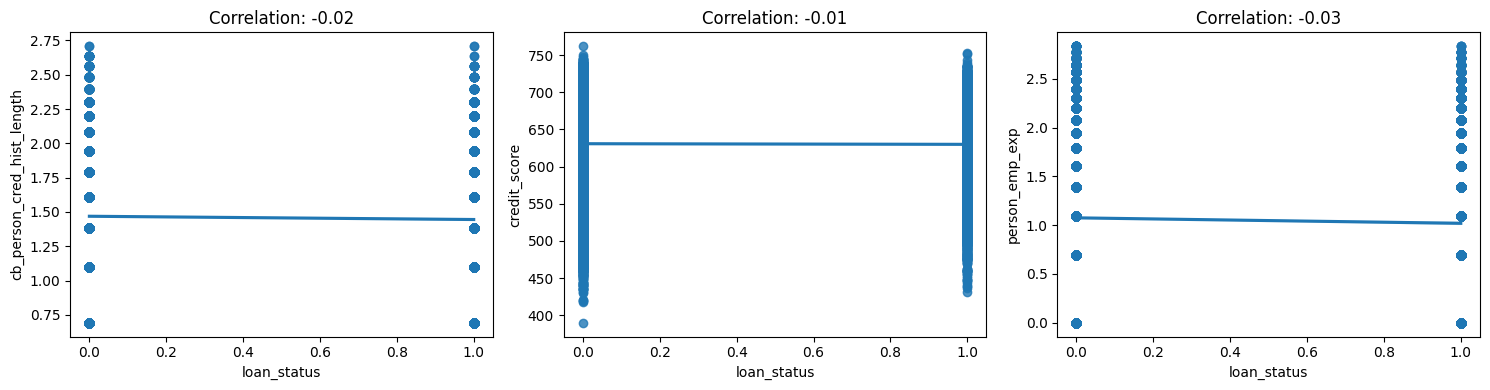

In [11]:
# Let's visualize the weakly correlated features separately
features = ['cb_person_cred_hist_length', 'credit_score', 'person_emp_exp']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 3 subplots side by side

# 1 jointplot on the first axis
sns.regplot(
    ax=axes[0],
    data=df,
    x='loan_status',
    y='cb_person_cred_hist_length'
)
axes[0].set_title(f"Correlation: {df['loan_status'].corr(df[features[0]]):.2f}")

# 2 jointplot on the second axis
sns.regplot(
    ax=axes[1],
    data=df,
    x='loan_status',
    y='credit_score'
)
axes[1].set_title(f"Correlation: {df['loan_status'].corr(df[features[1]]):.2f}")

# 3 jointplot on the third axis
sns.regplot(
    ax=axes[2],
    data=df,
    x='loan_status',
    y='person_emp_exp'
)
axes[2].set_title(f"Correlation: {df['loan_status'].corr(df[features[2]]):.2f}")

# Adjust layout
plt.tight_layout()
plt.show()


As we can see, the line for each chart is almost horizontal. It shows that there is almost no relationship between the features and the target. 

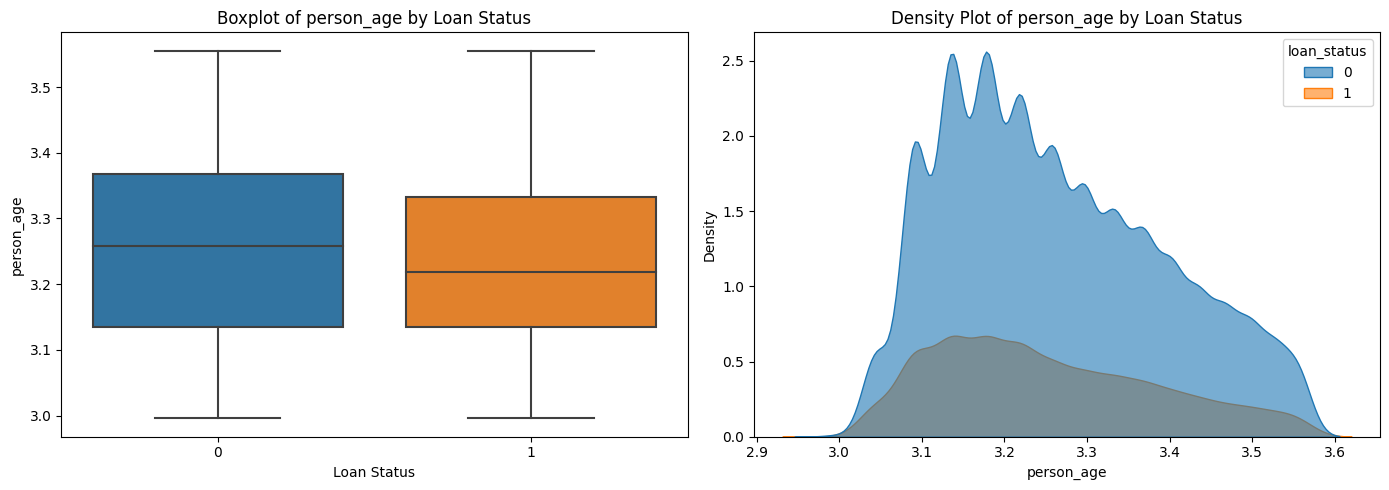

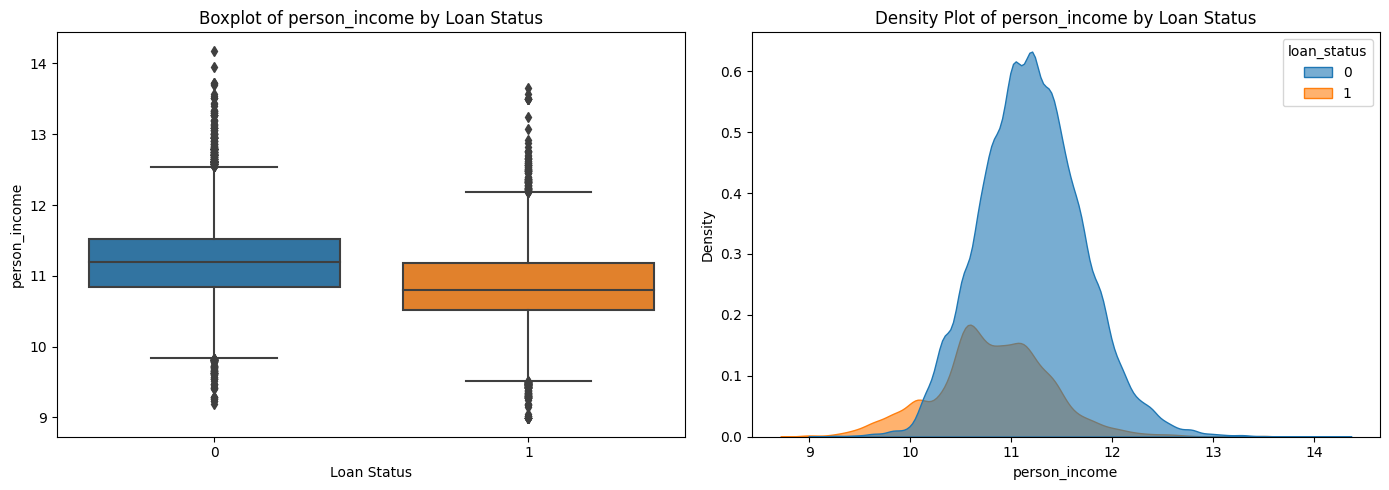

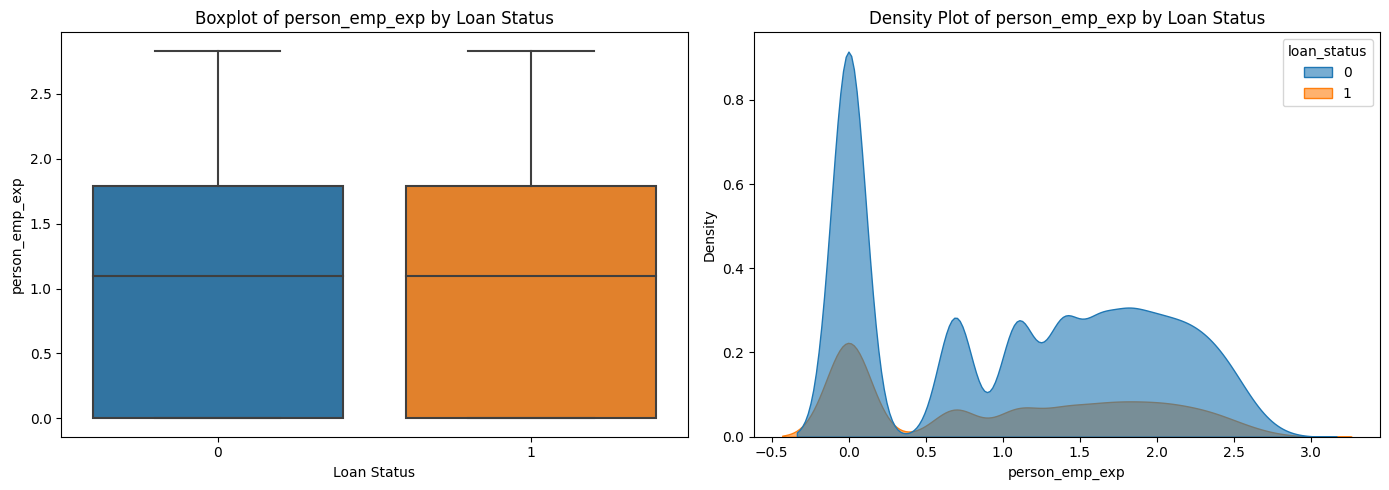

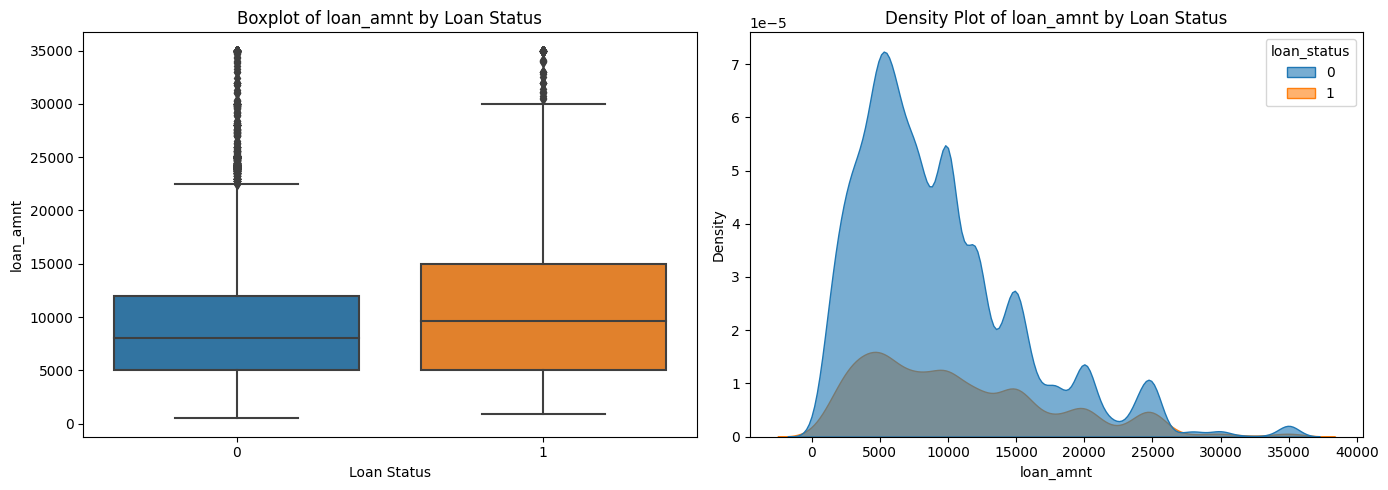

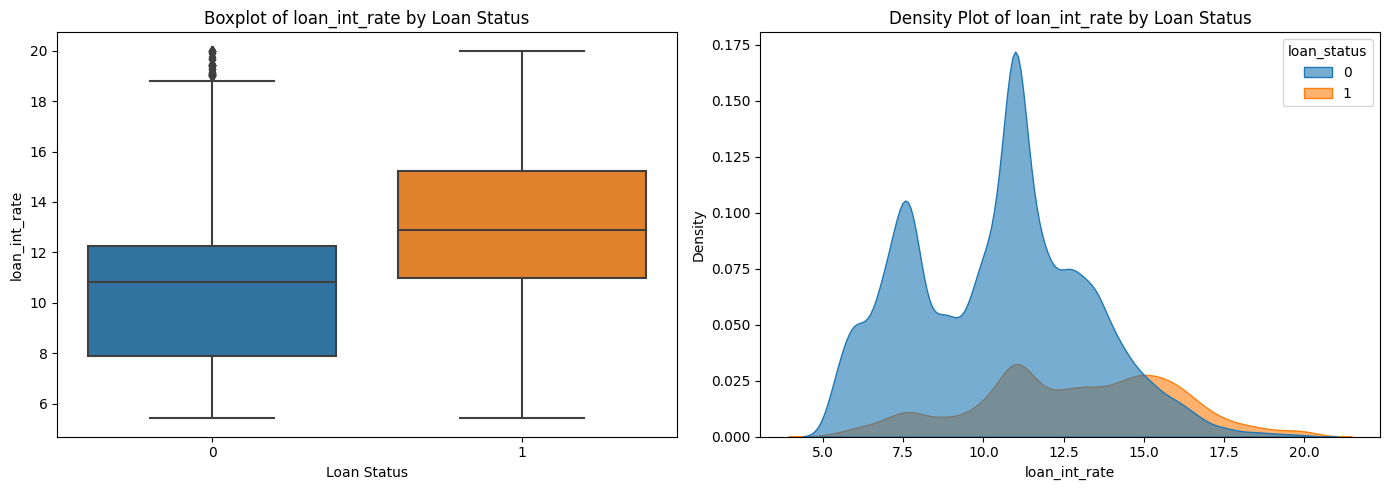

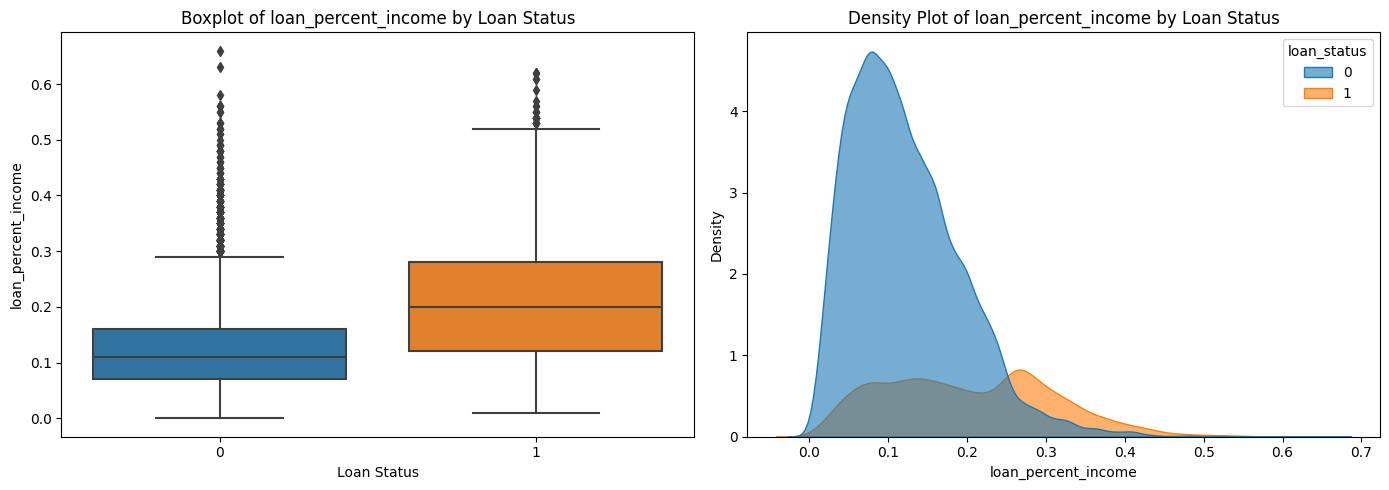

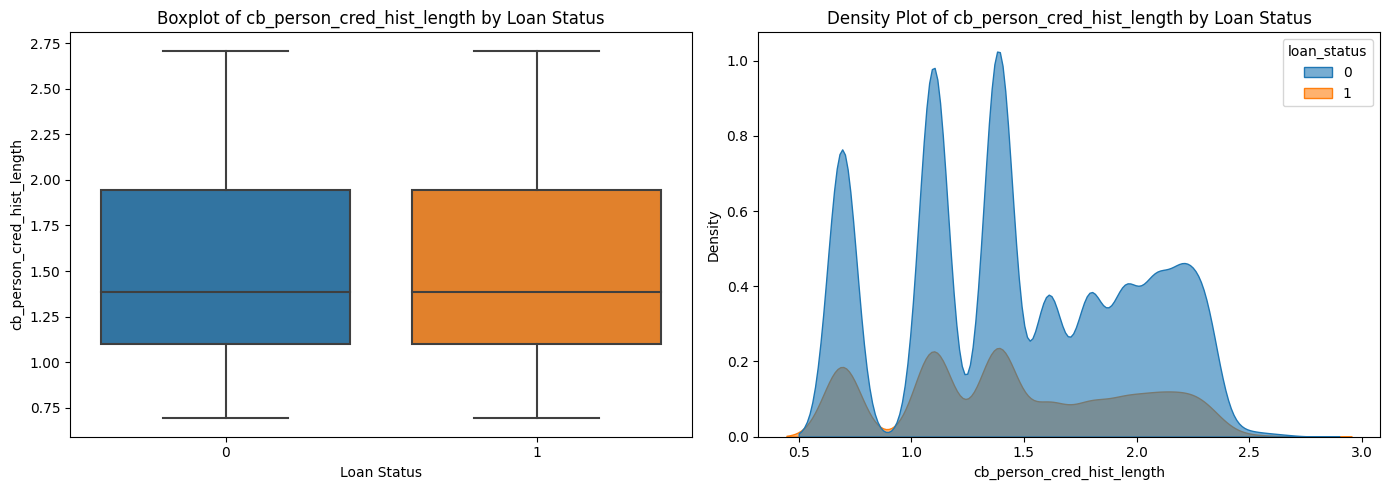

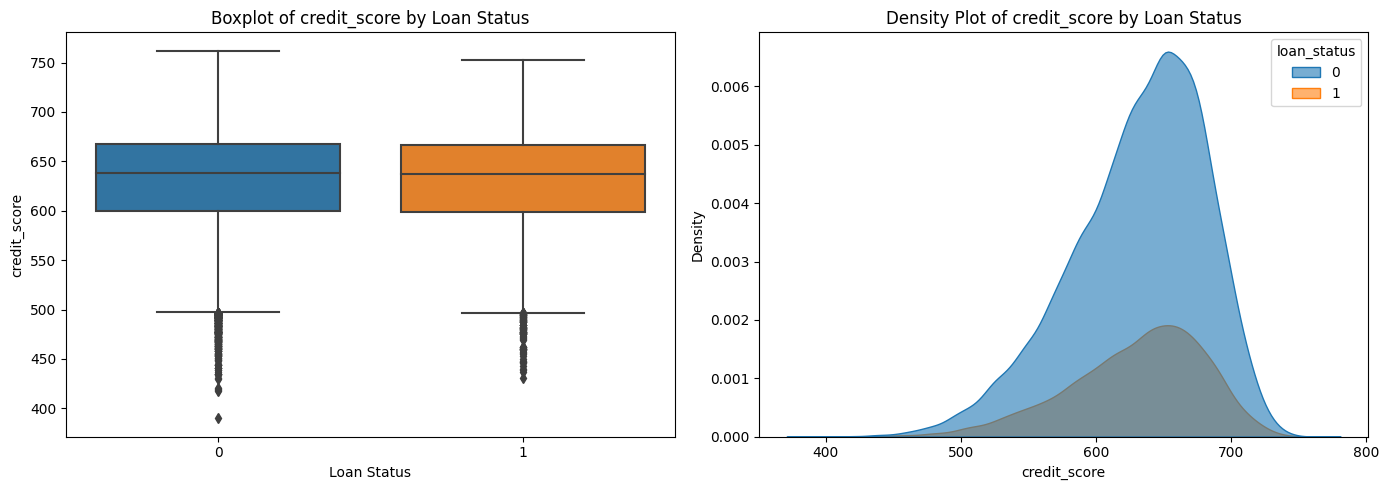

In [12]:
numeric_features = [
    'person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
    'credit_score'
] # because i don't want to visualize the relationship of the target with itself

# Loop through each numeric feature
for col in numeric_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # Boxplot grouped by target class
    sns.boxplot(x='loan_status', y=col, data=df, ax=axes[0])
    axes[0].set_title(f'Boxplot of {col} by Loan Status')
    axes[0].set_xlabel('Loan Status')
    axes[0].set_ylabel(col)
    # KDE plot for each target class
    sns.kdeplot(data=df, x=col, hue='loan_status', fill=True, ax=axes[1], alpha=0.6)
    axes[1].set_title(f'Density Plot of {col} by Loan Status')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Density')
    plt.tight_layout()
    plt.show()


We can see that the weakly correlated features actually have almost the same distribution for both negative and positive classes. Other features have different distributions depending on the class. 

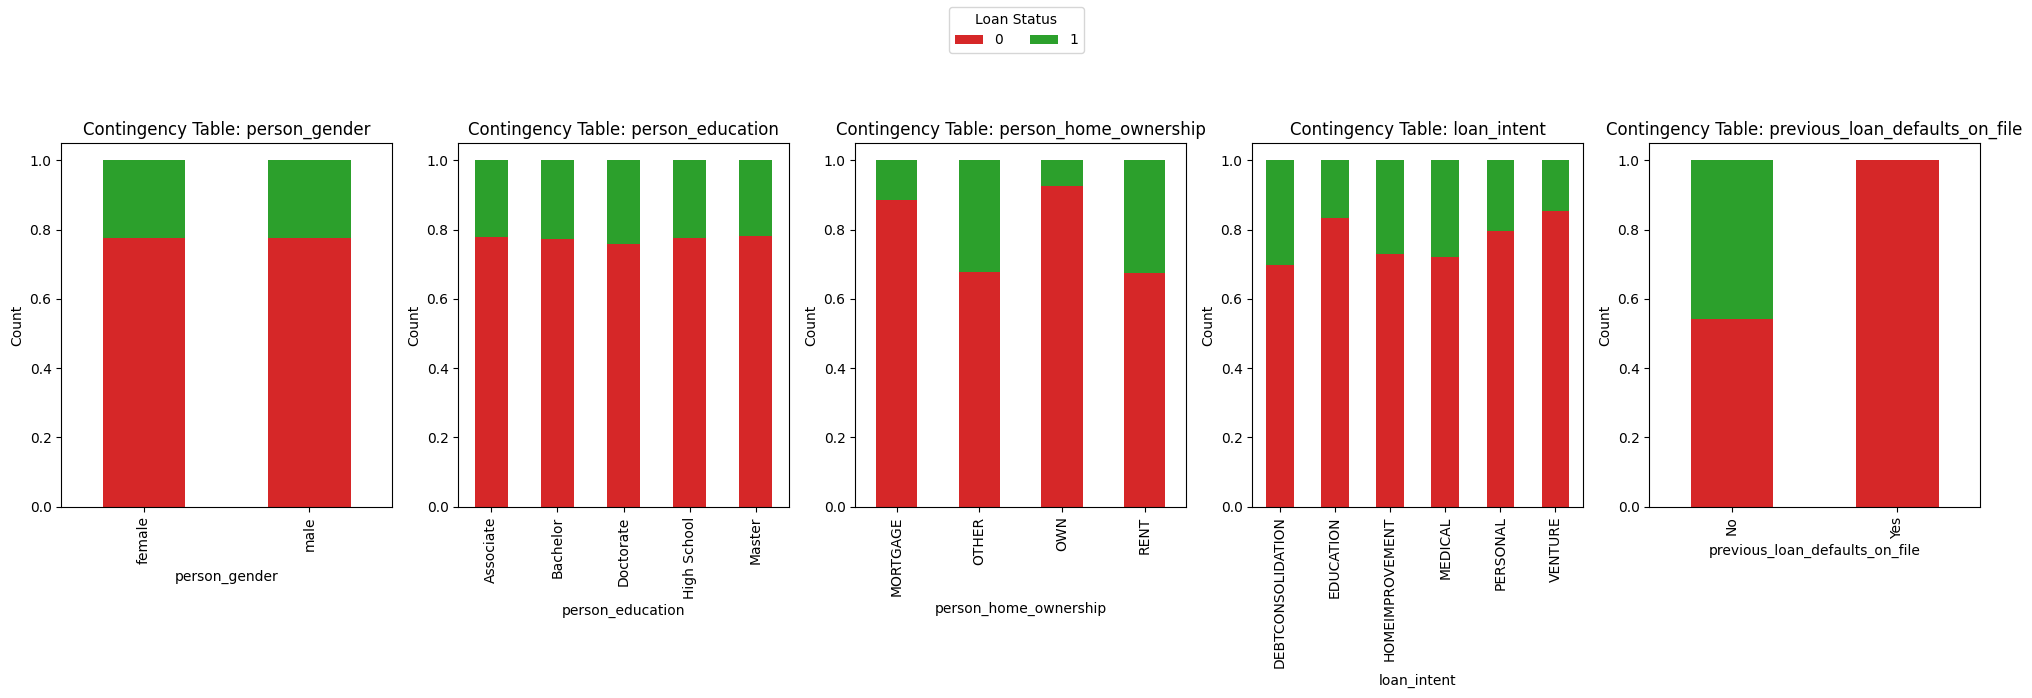

In [13]:
# Create the subplot grid: Two rows (count plot and contingency table) for each feature
fig, axs = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(20, 7))
for i, feature in enumerate(categorical_features):
    # Contingency table for each feature
    contingency_table = pd.crosstab(df[feature], df['loan_status'], normalize='index')
    contingency_table.plot(
        kind='bar', 
        stacked=True, 
        color=['#d62728', '#2ca02c'], 
        ax=axs[i], 
        legend=False
    )
    axs[i].set_title(f'Contingency Table: {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Add a legend to the bottom row
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Loan Status')

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(top=0.8)  # Leave space for the legend
plt.show()

We compare the proportion of each class for each unique value of the feature. As we can see, a person's gender and his education do not affect on the target. 

In [14]:
# we delete unrelated features
features_to_delete = ['person_gender', 'person_education', 'credit_score', 'cb_person_cred_hist_length', 'person_emp_exp']
df = df.drop(features_to_delete, axis = 1)
df

,person_age,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,loan_status
0,3.091042,11.183699,RENT,35000.0,PERSONAL,16.02,0.49,No,1
1,3.044522,9.415890,OWN,1000.0,EDUCATION,11.14,0.08,Yes,0
2,3.218876,9.428512,MORTGAGE,5500.0,MEDICAL,12.87,0.44,No,1
3,3.135494,11.286690,RENT,35000.0,MEDICAL,15.23,0.44,No,1
4,3.178054,11.099453,RENT,35000.0,MEDICAL,14.27,0.53,No,1
...,...,...,...,...,...,...,...,...,...
44994,3.178054,10.371113,RENT,12229.0,MEDICAL,10.70,0.38,No,1
44995,3.295837,10.778352,RENT,15000.0,MEDICAL,15.66,0.31,No,1
44997,3.496508,10.949788,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,No,1
44998,3.367296,10.409220,RENT,12000.0,EDUCATION,13.23,0.36,No,1


**Mini conclusion**

In this section, I removed outliers, performed logarithm transformation for some features, investigated each feature and its relationship with our target, and deleted weakly related features. 

# Binarization


I will binarize numeric features using inter-ordinal scale, because I want to split people into categories. For categorical features, I would use nominal scale, because it's more convenient and there is no way to sort them. 

In [15]:
X = df.drop('loan_status', axis = 1)
y = df['loan_status']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # make sure stratify = y because we have imbalanced class

## Numeric Features

In [17]:
# this function generates inter-ordinal scale according to the given threshold. Due to the threshold chosen, sometimes there might be columns with single value, we need to delete them
def transform_numeric(col, thresholds, threshold_names, X):
    feature = col 
    for i, threshold in enumerate(thresholds):
        X[f'{col}_le_{threshold_names[i]}'] = X[feature] <= threshold
        X[f'{col}_ge_{threshold_names[i]}'] = X[feature] >= threshold
    for i, threshold in enumerate(thresholds): # convert to 1 and 0
        X[f'{col}_le_{threshold_names[i]}'] = (X[f'{col}_le_{threshold_names[i]}']).astype(int)
        X[f'{col}_ge_{threshold_names[i]}'] = (X[f'{col}_ge_{threshold_names[i]}']).astype(int)
    X = X.drop([feature], axis=1) # delete the feature itself
    X = X.loc[:, X.nunique() > 1] # delete columns with a single value
    display(X)
    return X

**For each numeric feature, we pick appropriate thresholds based on X_train, bins should be more or less balanced**

### Person_age

Age of the person. We will use inter-ordinal scale with thresholds 20-25-30-35. The reason I use this scale is because I want to split people into age categories.

In [18]:

thresholds = np.log([19, 23, 25, 28, 36])
X_train['AgeCategory'] = pd.cut(
        X_train['person_age'],
        bins=thresholds,
        labels=['20-23', '23-25', '25-28', '>28']
    )
X_train['AgeCategory'].isna().sum()
X_train['AgeCategory'].value_counts(False)

AgeCategory
20-23    8740
>28      8425
23-25    7639
25-28    7607
Name: count, dtype: int64

In [19]:
feature = 'person_age'
threshold_names = [20, 23, 25, 28, '>28']
X = transform_numeric(feature, thresholds, threshold_names, X)

,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28
0,11.183699,RENT,35000.0,PERSONAL,16.02,0.49,No,1,0,1,0,1,0
1,9.415890,OWN,1000.0,EDUCATION,11.14,0.08,Yes,1,0,1,0,1,0
2,9.428512,MORTGAGE,5500.0,MEDICAL,12.87,0.44,No,0,1,1,1,1,0
3,11.286690,RENT,35000.0,MEDICAL,15.23,0.44,No,1,1,1,0,1,0
4,11.099453,RENT,35000.0,MEDICAL,14.27,0.53,No,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,10.371113,RENT,12229.0,MEDICAL,10.70,0.38,No,0,1,1,0,1,0
44995,10.778352,RENT,15000.0,MEDICAL,15.66,0.31,No,0,1,0,1,1,0
44997,10.949788,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,No,0,1,0,1,0,1
44998,10.409220,RENT,12000.0,EDUCATION,13.23,0.36,No,0,1,0,1,0,1


### Person_income

Annual income, let's divide the income column into several equal bins.

In [20]:
thresholds = np.log([10000, 45000, 70000, 100000, 200000])
print(thresholds)
X_train['IncomeCategory'] = pd.cut(
        X_train['person_income'],
        bins=thresholds,
        labels=['income_10k_45k', 'income_45k_70k', 'income_70k_100k', 'income_>100k']
    )
X_train['IncomeCategory'].isna().sum()
X_train['IncomeCategory'].value_counts(False)

[ 9.21034037 10.71441777 11.15625052 11.51292546 12.20607265]


IncomeCategory
income_45k_70k     9756
income_70k_100k    8131
income_10k_45k     7489
income_>100k       6218
Name: count, dtype: int64

In [21]:
feature = 'person_income'
threshold_names = ['10k_45k', '45k_70k', '70k_100k', '100k_200k', '>200k']
X = transform_numeric(feature, thresholds, threshold_names, X)

,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28,person_income_le_10k_45k,person_income_ge_10k_45k,person_income_le_45k_70k,person_income_ge_45k_70k,person_income_le_70k_100k,person_income_ge_70k_100k,person_income_le_100k_200k,person_income_ge_100k_200k,person_income_le_>200k,person_income_ge_>200k
0,RENT,35000.0,PERSONAL,16.02,0.49,No,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0
1,OWN,1000.0,EDUCATION,11.14,0.08,Yes,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0
2,MORTGAGE,5500.0,MEDICAL,12.87,0.44,No,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0
3,RENT,35000.0,MEDICAL,15.23,0.44,No,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0
4,RENT,35000.0,MEDICAL,14.27,0.53,No,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,RENT,12229.0,MEDICAL,10.70,0.38,No,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0
44995,RENT,15000.0,MEDICAL,15.66,0.31,No,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0
44997,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,No,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
44998,RENT,12000.0,EDUCATION,13.23,0.36,No,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0


### Loan_amnt

Loan amount requested. 

In [22]:
X_train['loan_amnt'].describe()

count    32411.000000
mean      9517.781802
std       6243.634941
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [23]:
thresholds = [499, 3000, 5000, 7000, 9000, 11000, 17000, 36000]
print(thresholds)
X_train['LoanCategory'] = pd.cut(
        X_train['loan_amnt'],
        bins=thresholds,
        labels=['loan_less_than_3k', 'loan_3k_5k', 'loan_5k_7k', 'loan_7k_9k', 'loan_9k_11k', 'loan_11k_17k', 'loan_>17k']
    )
X_train['LoanCategory'].isna().sum()
X_train['LoanCategory'].value_counts()

[499, 3000, 5000, 7000, 9000, 11000, 17000, 36000]


LoanCategory
loan_11k_17k         6329
loan_3k_5k           5580
loan_5k_7k           4640
loan_9k_11k          4041
loan_less_than_3k    3973
loan_7k_9k           3943
loan_>17k            3905
Name: count, dtype: int64

In [24]:
feature = 'loan_amnt'
thresholds = [X_train[feature].min(), 3000, 5000, 7000, 9000, 11000, 17000, 36000]
threshold_names = ['less_3k', '3k_5k', '5k_7k', '7k_9k', '9k_11k', '11k_17k', '17k_36k', 'more_than_36k']
X = transform_numeric(feature, thresholds, threshold_names, X)

,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28,person_income_le_10k_45k,person_income_ge_10k_45k,person_income_le_45k_70k,person_income_ge_45k_70k,person_income_le_70k_100k,person_income_ge_70k_100k,person_income_le_100k_200k,person_income_ge_100k_200k,person_income_le_>200k,person_income_ge_>200k,loan_amnt_le_less_3k,loan_amnt_le_3k_5k,loan_amnt_ge_3k_5k,loan_amnt_le_5k_7k,loan_amnt_ge_5k_7k,loan_amnt_le_7k_9k,loan_amnt_ge_7k_9k,loan_amnt_le_9k_11k,loan_amnt_ge_9k_11k,loan_amnt_le_11k_17k,loan_amnt_ge_11k_17k,loan_amnt_le_17k_36k,loan_amnt_ge_17k_36k
0,RENT,PERSONAL,16.02,0.49,No,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
1,OWN,EDUCATION,11.14,0.08,Yes,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
2,MORTGAGE,MEDICAL,12.87,0.44,No,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0
3,RENT,MEDICAL,15.23,0.44,No,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
4,RENT,MEDICAL,14.27,0.53,No,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,RENT,MEDICAL,10.70,0.38,No,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0
44995,RENT,MEDICAL,15.66,0.31,No,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0
44997,RENT,DEBTCONSOLIDATION,10.02,0.05,No,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
44998,RENT,EDUCATION,13.23,0.36,No,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0


## Loan_int_rate

In [25]:
thresholds = [5, 8, 10, 11, 12, 14, 21]
X_train['InterestCategory'] = pd.cut(
        X_train['loan_int_rate'],
        bins=thresholds,
        labels=['interest_5_8', 'interest_8_10', 'interest_10_11', 'interest_11_12', 'interest_12_14', 'interest_14_20']
    )
X_train['InterestCategory'].isna().sum()
X_train['InterestCategory'].value_counts()

InterestCategory
interest_5_8      7299
interest_11_12    6116
interest_12_14    5731
interest_14_20    5257
interest_8_10     4333
interest_10_11    3675
Name: count, dtype: int64

In [26]:
feature = 'loan_int_rate'
thresholds = [X_train[feature].min(), 8, 10, 11, 12, 14, X_train[feature].max()]
threshold_names = ['interest_5_8', 'interest_8_10', 'interest_10_11', 'interest_11_12', 'interest_12_14', 'interest_14_20', 'interest_more_20']
X = transform_numeric(feature, thresholds, threshold_names, X)

,person_home_ownership,loan_intent,loan_percent_income,previous_loan_defaults_on_file,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28,person_income_le_10k_45k,person_income_ge_10k_45k,person_income_le_45k_70k,person_income_ge_45k_70k,person_income_le_70k_100k,person_income_ge_70k_100k,person_income_le_100k_200k,person_income_ge_100k_200k,person_income_le_>200k,person_income_ge_>200k,loan_amnt_le_less_3k,loan_amnt_le_3k_5k,loan_amnt_ge_3k_5k,loan_amnt_le_5k_7k,loan_amnt_ge_5k_7k,loan_amnt_le_7k_9k,loan_amnt_ge_7k_9k,loan_amnt_le_9k_11k,loan_amnt_ge_9k_11k,loan_amnt_le_11k_17k,loan_amnt_ge_11k_17k,loan_amnt_le_17k_36k,loan_amnt_ge_17k_36k,loan_int_rate_le_interest_5_8,loan_int_rate_le_interest_8_10,loan_int_rate_ge_interest_8_10,loan_int_rate_le_interest_10_11,loan_int_rate_ge_interest_10_11,loan_int_rate_le_interest_11_12,loan_int_rate_ge_interest_11_12,loan_int_rate_le_interest_12_14,loan_int_rate_ge_interest_12_14,loan_int_rate_le_interest_14_20,loan_int_rate_ge_interest_14_20,loan_int_rate_ge_interest_more_20
0,RENT,PERSONAL,0.49,No,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
1,OWN,EDUCATION,0.08,Yes,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0
2,MORTGAGE,MEDICAL,0.44,No,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0
3,RENT,MEDICAL,0.44,No,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
4,RENT,MEDICAL,0.53,No,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,RENT,MEDICAL,0.38,No,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0
44995,RENT,MEDICAL,0.31,No,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0
44997,RENT,DEBTCONSOLIDATION,0.05,No,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0
44998,RENT,EDUCATION,0.36,No,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,0


### Loan_percent_income

Loan amount as a percentage of annual income

In [27]:
thresholds = [-1, 0.05, 0.08, 0.12, 0.15, 0.2, 0.5]
X_train['PercCategory'] = pd.cut(
        X_train['loan_percent_income'],
        bins=thresholds,
        labels=['percent_5', 'percent_5_8', 'percent_8_12', 'percent_12_15', 'percent_15_20', 'percent_more_20']
    )
X_train['PercCategory'].isna().sum()
X_train['PercCategory'].value_counts()

PercCategory
percent_more_20    6607
percent_8_12       6513
percent_5_8        5244
percent_15_20      5105
percent_5          4886
percent_12_15      4015
Name: count, dtype: int64

In [28]:
feature = 'loan_percent_income'
thresholds = [X_train[feature].min(), 0.05, 0.08, 0.12, 0.15, 0.2, 0.]
threshold_names = ['percent_5', 'percent_5_8', 'percent_8_12', 'percent_12_15', 'percent_15_20', 'percent_20_50', 'more_than_50']
X = transform_numeric(feature, thresholds, threshold_names, X)

,person_home_ownership,loan_intent,previous_loan_defaults_on_file,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28,person_income_le_10k_45k,person_income_ge_10k_45k,person_income_le_45k_70k,person_income_ge_45k_70k,person_income_le_70k_100k,person_income_ge_70k_100k,person_income_le_100k_200k,person_income_ge_100k_200k,person_income_le_>200k,person_income_ge_>200k,loan_amnt_le_less_3k,loan_amnt_le_3k_5k,loan_amnt_ge_3k_5k,loan_amnt_le_5k_7k,loan_amnt_ge_5k_7k,loan_amnt_le_7k_9k,loan_amnt_ge_7k_9k,loan_amnt_le_9k_11k,loan_amnt_ge_9k_11k,loan_amnt_le_11k_17k,loan_amnt_ge_11k_17k,loan_amnt_le_17k_36k,loan_amnt_ge_17k_36k,loan_int_rate_le_interest_5_8,loan_int_rate_le_interest_8_10,loan_int_rate_ge_interest_8_10,loan_int_rate_le_interest_10_11,loan_int_rate_ge_interest_10_11,loan_int_rate_le_interest_11_12,loan_int_rate_ge_interest_11_12,loan_int_rate_le_interest_12_14,loan_int_rate_ge_interest_12_14,loan_int_rate_le_interest_14_20,loan_int_rate_ge_interest_14_20,loan_int_rate_ge_interest_more_20,loan_percent_income_le_percent_5,loan_percent_income_le_percent_5_8,loan_percent_income_ge_percent_5_8,loan_percent_income_le_percent_8_12,loan_percent_income_ge_percent_8_12,loan_percent_income_le_percent_12_15,loan_percent_income_ge_percent_12_15,loan_percent_income_le_percent_15_20,loan_percent_income_ge_percent_15_20,loan_percent_income_le_percent_20_50,loan_percent_income_ge_percent_20_50,loan_percent_income_le_more_than_50
0,RENT,PERSONAL,No,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0
1,OWN,EDUCATION,Yes,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,0,1,0,0
2,MORTGAGE,MEDICAL,No,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
3,RENT,MEDICAL,No,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0
4,RENT,MEDICAL,No,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,RENT,MEDICAL,No,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
44995,RENT,MEDICAL,No,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0
44997,RENT,DEBTCONSOLIDATION,No,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,0
44998,RENT,EDUCATION,No,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0


At this step we can see that all numeric features are processed. Now let's use OneHot / nominal scaling to transform categorical features. The easiest way is to get "dummies" using pandas' built-in function. 

In [29]:
X = pd.get_dummies(X, dtype='int')

In [30]:
X

,person_age_le_23,person_age_ge_23,person_age_le_25,person_age_ge_25,person_age_le_28,person_age_ge_28,person_income_le_10k_45k,person_income_ge_10k_45k,person_income_le_45k_70k,person_income_ge_45k_70k,person_income_le_70k_100k,person_income_ge_70k_100k,person_income_le_100k_200k,person_income_ge_100k_200k,person_income_le_>200k,person_income_ge_>200k,loan_amnt_le_less_3k,loan_amnt_le_3k_5k,loan_amnt_ge_3k_5k,loan_amnt_le_5k_7k,loan_amnt_ge_5k_7k,loan_amnt_le_7k_9k,loan_amnt_ge_7k_9k,loan_amnt_le_9k_11k,loan_amnt_ge_9k_11k,loan_amnt_le_11k_17k,loan_amnt_ge_11k_17k,loan_amnt_le_17k_36k,loan_amnt_ge_17k_36k,loan_int_rate_le_interest_5_8,loan_int_rate_le_interest_8_10,loan_int_rate_ge_interest_8_10,loan_int_rate_le_interest_10_11,loan_int_rate_ge_interest_10_11,loan_int_rate_le_interest_11_12,loan_int_rate_ge_interest_11_12,loan_int_rate_le_interest_12_14,loan_int_rate_ge_interest_12_14,loan_int_rate_le_interest_14_20,loan_int_rate_ge_interest_14_20,loan_int_rate_ge_interest_more_20,loan_percent_income_le_percent_5,loan_percent_income_le_percent_5_8,loan_percent_income_ge_percent_5_8,loan_percent_income_le_percent_8_12,loan_percent_income_ge_percent_8_12,loan_percent_income_le_percent_12_15,loan_percent_income_ge_percent_12_15,loan_percent_income_le_percent_15_20,loan_percent_income_ge_percent_15_20,loan_percent_income_le_percent_20_50,loan_percent_income_ge_percent_20_50,loan_percent_income_le_more_than_50,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,1,1,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
4,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
44995,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
44997,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
44998,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


In [31]:
# now we've transformed the dataset. let's make sure that there is no column with only one unique value. 
for col in X.columns:
    if X[col].nunique() == X.shape[0]:
        print("Something is not right in col", col)

In [32]:
X.isna().sum().sum() # let's notice there is no empty cells in the dataset. 

0

In [33]:
X.shape

(40514, 65)

# Vanilla Lazy FCA

In [34]:
# Because of the time complexity, 40k rows is way too much. Let's sample approximately equal amount of positive and negative elements
X_positive = X[y == 1]
X_negative = X[y == 0]
X_positive_balanced = X_positive.sample(frac=0.2, random_state=42)
X_negative_balanced = X_negative.sample(frac=0.04, random_state=42)
print(X_positive_balanced.shape, X_negative_balanced.shape)
# Combine the balanced datasets
X_balanced = pd.concat([X_positive_balanced, X_negative_balanced]).reset_index(drop=True)
y_balanced = pd.concat([y.loc[X_positive_balanced.index], y.loc[X_negative_balanced.index]]).reset_index(drop=True).values
print(X_balanced.shape, y_balanced.shape)

(1812, 65) (1258, 65)
(3070, 65) (3070,)


In [35]:
# resplit the dataset
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, stratify=y_balanced, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [36]:
# The metrics used 
def metric(y_pred, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()    
    print("Lazy FCA Performance Metrics:")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall (Sensitivity): {recall_score(y_true, y_pred):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}")
    print(f"Negative Predictive Value: {tn / (tn + fn):.4f}")
    print(f"False Positive Rate: {fp / (fp + tn):.4f}")
    print(f"False Discovery Rate: {fp / (fp + tp):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


In [37]:
# Vanilla baseline
class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_pos_array = self.X_train[self.y_train == 1].reset_index(drop=True).values.astype(bool)
        self.X_neg_array = self.X_train[self.y_train == 0].reset_index(drop=True).values.astype(bool)

    def classify_sample(self, sample: pd.Series, verbose: bool = False) -> Any:
        sample_array = sample.values.astype(bool).reshape(1, -1)
        positive_classifiers = 0
        negative_classifiers = 0
    
        # Calculate intersections
        intersections_pos = np.logical_and(self.X_pos_array, sample_array)
        intersections_neg = np.logical_and(self.X_neg_array, sample_array)
    
        # Check positive classifiers
        for intersection in intersections_pos:
            pos_cover = np.any(np.all(self.X_pos_array == intersection.reshape(1, -1), axis=1))
            neg_cover = np.any(np.all(self.X_neg_array == intersection.reshape(1, -1), axis=1))
            if pos_cover and not neg_cover:
                positive_classifiers += 1 # if it is positive and not negative classifier
    
        # Check negative classifiers
        for intersection in intersections_neg:
            neg_cover = np.any(np.all(self.X_neg_array == intersection.reshape(1, -1), axis=1))
            pos_cover = np.any(np.all(self.X_pos_array == intersection.reshape(1, -1), axis=1))
            if neg_cover and not pos_cover:
                negative_classifiers += 1
    
        # Default prediction if no classifiers found
        if positive_classifiers == 0 and negative_classifiers == 0:
            prediction = 1 # 1 because there are more positive elements in the dataset
        else:
            prediction = 1 if positive_classifiers > negative_classifiers else 0
    
        if verbose:
            print(
                f"Sample {sample.name} is classified as {prediction}, "
                f"positive_classifiers={positive_classifiers}, "
                f"negative_classifiers={negative_classifiers}"
            )
        return prediction

    def predict(self, X_test: pd.DataFrame, verbose: bool = False) -> List[Any]:
        predictions = []
        for _, sample in tqdm(X_test.iterrows()):
            prediction = self.classify_sample(sample, verbose)
            predictions.append(prediction)
        return predictions

In [38]:
pos_X_train = X_train[y_train == 1]
neg_X_train = X_train[y_train == 0]
len(pos_X_train), len(neg_X_train)

(1450, 1006)

In [39]:
sample = X_test.iloc[0]
classifier = LazyClassifierFCA()
classifier.fit(X_train, y_train)
classifier.classify_sample(sample, verbose=True) # as we can see, everything is interpretative. 

Sample 0 is classified as 1, positive_classifiers=0, negative_classifiers=0


1

In [40]:
y_pred_vanilla = classifier.predict(X_test)
print(pd.Series(y_pred_vanilla).value_counts())
metric(y_test, y_pred_vanilla) 

614it [01:22,  7.41it/s]

1    600
0     14
Name: count, dtype: int64
Lazy FCA Performance Metrics:
True Positives: 360
True Negatives: 12
False Positives: 2
False Negatives: 240
Accuracy: 0.6059
Precision: 0.9945
Recall (Sensitivity): 0.6000
Specificity: 0.8571
Negative Predictive Value: 0.0476
False Positive Rate: 0.1429
False Discovery Rate: 0.0055
F1 Score: 0.7484


**Mini conclusion**

I've sampled a smaller and more balanced dataset, implemented lazy fca algorithm, measured its performance. It is noticeable, that the algorithm tends to classify elements as positive class because an element is be classified as positive by default. This happens because in this algorithm we look for exact matches, which can be rare in real life. 

# State-of-the-art methods

In [41]:
# funciton to fine-tune hyperparameters
def tune_model(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    print("==================================")
    print(f"{model_name}: Hyperparameter Tuning")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")
    y_pred = best_model.predict(X_test)
    print("Performance Metrics:")
    metric(y_test, y_pred)
    return best_model

In [42]:
# sample unbinarized version of dataset with the SAME indices
unbinarized_df = pd.concat([df.loc[X_positive_balanced.index], df.loc[X_negative_balanced.index]])
unbinarized_X = unbinarized_df.drop('loan_status', axis = 1)
unbinarized_y = unbinarized_df['loan_status']
unbinarized_X_train, unbinarized_X_test, unbinarized_y_train, unbinarized_y_test = train_test_split(unbinarized_X, unbinarized_y, stratify=unbinarized_y, test_size=0.2, random_state=42)
unbinarized_X_train = unbinarized_X_train.reset_index(drop=True)
unbinarized_X_test = unbinarized_X_test.reset_index(drop=True)

In [43]:
unbinarized_X_test

,person_age,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,previous_loan_defaults_on_file
0,3.218876,12.510586,MORTGAGE,21000.0,HOMEIMPROVEMENT,11.11,0.08,No
1,3.135494,11.416348,MORTGAGE,11000.0,MEDICAL,5.47,0.12,No
2,3.258097,11.197502,OWN,9800.0,VENTURE,11.01,0.13,Yes
3,3.135494,10.294719,RENT,5000.0,DEBTCONSOLIDATION,6.73,0.17,No
4,3.178054,10.270281,RENT,3500.0,PERSONAL,10.78,0.12,No
...,...,...,...,...,...,...,...,...
609,3.433987,11.420602,RENT,1200.0,PERSONAL,6.54,0.01,Yes
610,3.433987,10.081215,RENT,8500.0,HOMEIMPROVEMENT,11.01,0.36,No
611,3.526361,11.351406,RENT,4200.0,EDUCATION,14.61,0.05,No
612,3.178054,10.441383,MORTGAGE,6000.0,MEDICAL,15.62,0.18,No


In [44]:
numeric_features = unbinarized_X.select_dtypes(['int64', 'float64']).columns
categorical_features = unbinarized_X.select_dtypes('object').columns

In [45]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Separately preprocess numeric features
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(unbinarized_X_train[numeric_features])
X_test_numeric = scaler.transform(unbinarized_X_test[numeric_features])

# Separately preprocess categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(unbinarized_X_train[categorical_features])
X_test_categorical = encoder.transform(unbinarized_X_test[categorical_features])

# Combine processed features
X_train_processed = np.hstack([X_train_numeric, X_train_categorical])
X_test_processed = np.hstack([X_test_numeric, X_test_categorical])

I fine tuned the hyperparameters of each algorithm both on binarized and unbinarized datasets. 

## KNN

In [46]:
# KNN
knn_params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
best_knn = tune_model(KNeighborsClassifier(), knn_params, X_train, y_train, X_test, y_test, "KNN")
best_knn_unbinarized = tune_model(KNeighborsClassifier(), knn_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "KNN")

KNN: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'n_neighbors': 9, 'weights': 'distance'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 333
True Negatives: 176
False Positives: 29
False Negatives: 76
Accuracy: 0.8290
Precision: 0.9199
Recall (Sensitivity): 0.8142
Specificity: 0.8585
Negative Predictive Value: 0.6984
False Positive Rate: 0.1415
False Discovery Rate: 0.0801
F1 Score: 0.8638
KNN: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'n_neighbors': 9, 'weights': 'distance'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 343
True Negatives: 188
False Positives: 19
False Negatives: 64
Accuracy: 0.8648
Precision: 0.9475
Recall (Sensitivity): 0.8428
Specificity: 0.9082
Negative Predictive Value: 0.7460
False Positive Rate: 0.0918
False Discovery Rate: 0.0525
F1 Score: 0.8921


## Naive Bayes

In [47]:
nb_params = {'alpha': [0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}
best_nb = tune_model(BernoulliNB(), nb_params, X_train, y_train, X_test, y_test, "Naive Bayes")
best_nb_unbinarized = tune_model(BernoulliNB(), nb_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "Naive Bayes")

Naive Bayes: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 309
True Negatives: 199
False Positives: 53
False Negatives: 53
Accuracy: 0.8274
Precision: 0.8536
Recall (Sensitivity): 0.8536
Specificity: 0.7897
Negative Predictive Value: 0.7897
False Positive Rate: 0.2103
False Discovery Rate: 0.1464
F1 Score: 0.8536
Naive Bayes: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 346
True Negatives: 177
False Positives: 16
False Negatives: 75
Accuracy: 0.8518
Precision: 0.9558
Recall (Sensitivity): 0.8219
Specificity: 0.9171
Negative Predictive Value: 0.7024
False Positive Rate: 0.0829
False Discovery Rate: 0.0442
F1 Score: 0.8838


## Logistic Regression

In [48]:
lr_params = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
best_lr = tune_model(LogisticRegression(random_state=42, max_iter=1000), lr_params, X_train, y_train, X_test, y_test, "Logistic Regression")
best_lr_unbinarized = tune_model(LogisticRegression(random_state=42, max_iter=1000), lr_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "Logistic Regression")

Logistic Regression: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 1, 'solver': 'liblinear'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 338
True Negatives: 189
False Positives: 24
False Negatives: 63
Accuracy: 0.8583
Precision: 0.9337
Recall (Sensitivity): 0.8429
Specificity: 0.8873
Negative Predictive Value: 0.7500
False Positive Rate: 0.1127
False Discovery Rate: 0.0663
F1 Score: 0.8860
Logistic Regression: Hyperparameter Tuning
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 342
True Negatives: 182
False Positives: 20
False Negatives: 70
Accuracy: 0.8534
Precision: 0.9448
Recall (Sensitivity): 0.8301
Specificity: 0.9010
Negative Predictive Value: 0.7222
False Positive Rate: 0.0990
False Discovery Rate: 0.0552
F1 Score: 0.8837


## Support Vector Machine

In [49]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
best_svm = tune_model(SVC(random_state=42), svm_params, X_train, y_train, X_test, y_test, "SVM")
best_svm_unbinarized = tune_model(SVC(random_state=42), svm_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "SVM")

SVM: Hyperparameter Tuning
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 343
True Negatives: 184
False Positives: 19
False Negatives: 68
Accuracy: 0.8583
Precision: 0.9475
Recall (Sensitivity): 0.8345
Specificity: 0.9064
Negative Predictive Value: 0.7302
False Positive Rate: 0.0936
False Discovery Rate: 0.0525
F1 Score: 0.8875
SVM: Hyperparameter Tuning
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 346
True Negatives: 190
False Positives: 16
False Negatives: 62
Accuracy: 0.8730
Precision: 0.9558
Recall (Sensitivity): 0.8480
Specificity: 0.9223
Negative Predictive Value: 0.7540
False Positive Rate: 0.0777
False Discovery Rate: 0.0442
F1 Score: 0.8987


## Decision Tree

In [50]:
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]}
best_dt = tune_model(DecisionTreeClassifier(random_state=42), dt_params, X_train, y_train, X_test, y_test, "Decision Tree")
best_dt_unbinarized = tune_model(DecisionTreeClassifier(random_state=42), dt_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "Decision Tree")

Decision Tree: Hyperparameter Tuning
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 334
True Negatives: 182
False Positives: 28
False Negatives: 70
Accuracy: 0.8404
Precision: 0.9227
Recall (Sensitivity): 0.8267
Specificity: 0.8667
Negative Predictive Value: 0.7222
False Positive Rate: 0.1333
False Discovery Rate: 0.0773
F1 Score: 0.8721
Decision Tree: Hyperparameter Tuning
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 351
True Negatives: 176
False Positives: 11
False Negatives: 76
Accuracy: 0.8583
Precision: 0.9696
Recall (Sensitivity): 0.8220
Specificity: 0.9412
Negative Predictive Value: 0.6984
False Positive Rate: 0.0588
False Discovery Rate: 0.0304
F1 Score: 0.8897


## Random Forest

In [51]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]}
best_rf = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train, y_train, X_test, y_test, "Random Forest")
best_rf_unbinarized = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "Random Forest")

Random Forest: Hyperparameter Tuning
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 342
True Negatives: 183
False Positives: 20
False Negatives: 69
Accuracy: 0.8550
Precision: 0.9448
Recall (Sensitivity): 0.8321
Specificity: 0.9015
Negative Predictive Value: 0.7262
False Positive Rate: 0.0985
False Discovery Rate: 0.0552
F1 Score: 0.8849
Random Forest: Hyperparameter Tuning
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 345
True Negatives: 186
False Positives: 17
False Negatives: 66
Accuracy: 0.8648
Precision: 0.9530
Recall (Sensitivity): 0.8394
Specificity: 0.9163
Negative Predictive Value: 0.7381
False Positive Rate: 0.0837
False Discovery Rate: 0.0470
F1 Score: 0.8926

## XGBoost

In [52]:
xgb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
best_xgb = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train, y_train, X_test, y_test, "XGBoost")
best_xgb_unbinarized = tune_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_processed, unbinarized_y_train, X_test_processed, unbinarized_y_test, "XGBoost")

XGBoost: Hyperparameter Tuning
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 338
True Negatives: 192
False Positives: 24
False Negatives: 60
Accuracy: 0.8632
Precision: 0.9337
Recall (Sensitivity): 0.8492
Specificity: 0.8889
Negative Predictive Value: 0.7619
False Positive Rate: 0.1111
False Discovery Rate: 0.0663
F1 Score: 0.8895
XGBoost: Hyperparameter Tuning
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
Performance Metrics:
Lazy FCA Performance Metrics:
True Positives: 337
True Negatives: 206
False Positives: 25
False Negatives: 46
Accuracy: 0.8844
Precision: 0.9309
Recall (Sensitivity): 0.8799
Specificity: 0.8918
Negative Predictive Value: 0.8175
False Positive Rate: 0.1082
False Discovery Rate: 0.0691
F1 Score: 0.9047


# Optimization

In this section, I improved the vanilla algorithm by allowing imperfect matches. New hyperparameters are added:
* xxx - maximum counter examples
* min_cardinality - minimum number of intersection
* sample_threshold - threshold for the intersection to be accepted
* counter_threshold - threshold for the intersection to be rejected
* class_weight - weight for negative class because there are more positive elements in the dataset

In [53]:
class LazyClassifierFCA_UPDATED:
    def __init__(self):
        self.X_train = None
        self.y_train = None
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_pos_array = self.X_train[self.y_train == 1].reset_index(drop=True).values.astype(bool)
        self.X_neg_array = self.X_train[self.y_train == 0].reset_index(drop=True).values.astype(bool)
    def classify_sample(self, sample, verbose = False, xxx = 0, min_cardinality = 10, sample_threshold = 0.88, counter_threshold = 0.85, class_weight=1.5) -> Any:
        sample_array = sample.values.astype(bool).reshape(1, -1)
        positive_classifiers = 0
        negative_classifiers = 0
    
        # Calculate intersections
        intersections_pos = np.logical_and(self.X_pos_array, sample_array)
        intersections_neg = np.logical_and(self.X_neg_array, sample_array)
        
        # Check positive classifiers
        for intersection in intersections_pos:
            # Cardinality check for positive intersection
            intersection_cardinality = np.sum(intersection)
            if intersection_cardinality < min_cardinality: # skip if sum of intersection is less than min_cardinality
                continue
            # Calculate the proportion of matching elements for positive array
            pos_cover = np.any(np.mean(self.X_pos_array == intersection.reshape(1, -1), axis=1) >= sample_threshold)
            # Counter-examples for positive
            neg_cover_count = np.sum(np.mean(self.X_neg_array == intersection.reshape(1, -1), axis=1)  >= counter_threshold)
            if pos_cover and neg_cover_count <= xxx: # allowing some counter examples
                positive_classifiers += 1
        
        # Check negative classifiers, basically the same as for positive classifiers
        for intersection in intersections_neg:
            # Cardinality check for negative intersection
            intersection_cardinality = np.sum(intersection)
            if intersection_cardinality < min_cardinality:
                continue
            neg_cover = np.any(np.mean(self.X_neg_array == intersection.reshape(1, -1), axis=1) >= sample_threshold)
            pos_cover_count = np.sum(np.mean(self.X_pos_array == intersection.reshape(1, -1), axis=1)  >= counter_threshold)
            if neg_cover and pos_cover_count <= xxx:
                negative_classifiers += 1

        # Default prediction if no classifiers found
        if positive_classifiers == 0 and negative_classifiers == 0:
            prediction = 1 # because there are more positive elements
        else:
            prediction = 1 if positive_classifiers > negative_classifiers * class_weight else 0 # balance distribution by introducing class weight
        if verbose:
            print(
                f"Sample {sample.name} is classified as {prediction}, "
                f"positive_classifiers={positive_classifiers}, "
                f"negative_classifiers={negative_classifiers}, "
                f"min_cardinality={min_cardinality}, "
                f"max_counter_examples={xxx}"
            )
    
        return prediction

    def predict(self, X_test: pd.DataFrame, verbose: bool = False, xxx: int = 1, min_cardinality: int = 21, sample_threshold = 0.88, counter_threshold = 0.85, class_weight=1.5) -> List[Any]:
        predictions = []
        for _, sample in tqdm(X_test.iterrows(), total=X_test.shape[0]):
            prediction = self.classify_sample(sample, verbose, xxx, min_cardinality, sample_threshold, counter_threshold, class_weight)
            predictions.append(prediction)
        return predictions

In [54]:
from itertools import product
# we fine tune the hyperparameters

classifier = LazyClassifierFCA_UPDATED()
classifier.fit(X_train, y_train)

param_grid = {
    "xxx": [0, 1],
    "min_cardinality": [21, 31],
    "sample_threshold": [0.85, 0.88, 0.9],
    "counter_threshold": [0.83, 0.85, 0.9],
    "class_weight": [1.0, 1.5]
}

# Perform the grid search
best_params = None
best_score = 0
results = []

for params in product(
    param_grid["xxx"],
    param_grid["min_cardinality"],
    param_grid["sample_threshold"],
    param_grid["counter_threshold"],
    param_grid["class_weight"]
):
    xxx, min_cardinality, sample_threshold, counter_threshold, class_weight = params
    
    # Predict using the current hyperparameters
    y_pred = classifier.predict(
        X_test,
        verbose=False,
        xxx=xxx,
        min_cardinality=min_cardinality,
        sample_threshold=sample_threshold,
        counter_threshold=counter_threshold,
        class_weight=class_weight
    )
    
    # Evaluate the performance
    score = f1_score(y_test, y_pred)
    results.append((params, score))
    
    if score > best_score:
        best_score = score
        best_params = params

# Display the best parameters and their corresponding score
print("Best Parameters:", best_params)
print("Best metric:", best_score)

# Analyze all results
results_df = pd.DataFrame(results, columns=["Parameters", "F1 score"])
results_df = results_df.sort_values(by="F1 score", ascending=False)
results_df

100%|██████████| 614/614 [00:06<00:00, 98.47it/s] 

Best Parameters: (1, 21, 0.9, 0.85, 1.0)
Best metric: 0.8935064935064936


,Parameters,F1 score
51,"(1, 21, 0.9, 0.85, 1.5)",0.893506
50,"(1, 21, 0.9, 0.85, 1.0)",0.893506
45,"(1, 21, 0.88, 0.85, 1.5)",0.888598
44,"(1, 21, 0.88, 0.85, 1.0)",0.888598
38,"(1, 21, 0.85, 0.85, 1.0)",0.885677
...,...,...
22,"(0, 31, 0.85, 0.9, 1.0)",0.741803
21,"(0, 31, 0.85, 0.85, 1.5)",0.741803
20,"(0, 31, 0.85, 0.85, 1.0)",0.741803
19,"(0, 31, 0.85, 0.83, 1.5)",0.741803


In [55]:
classifier = LazyClassifierFCA_UPDATED()
classifier.fit(X_train, y_train)
xxx, min_cardinality, sample_threshold, counter_threshold, class_weight = best_params
y_pred_best = classifier.predict(
        X_test,
        verbose=False,
        xxx=xxx,
        min_cardinality=min_cardinality,
        sample_threshold=sample_threshold,
        counter_threshold=counter_threshold,
        class_weight=class_weight
    )
metric(y_test, y_pred_best)

100%|██████████| 614/614 [01:14<00:00,  8.23it/s]

Lazy FCA Performance Metrics:
True Positives: 344
True Negatives: 188
False Positives: 18
False Negatives: 64
Accuracy: 0.8664
Precision: 0.9503
Recall (Sensitivity): 0.8431
Specificity: 0.9126
Negative Predictive Value: 0.7460
False Positive Rate: 0.0874
False Discovery Rate: 0.0497
F1 Score: 0.8935


# Conclusion 

In this project, I selected a binary dataset on loan approval, consisting of both numeric and categorical features. The workflow began with data cleaning, including the removal of outliers, followed by preprocessing steps. Relationships between each feature and the target variable were thoroughly investigated, and all features were transformed into binary representations. 

Subsequently, I implemented the Lazy FCA baseline algorithm and evaluated its performance. Additionally, I applied several state-of-the-art methods, such as Random Forest and XGBoost, to the same dataset in both binarized and unbinarized versions, incorporating hyperparameter fine-tuning. The results indicated that Random Forest and XGBoost consistently achieved the best performance across both versions of the dataset.

Further, I improved the baseline Lazy FCA algorithm by introducing various thresholds and class weights. After fine-tuning the hyperparameters, the optimized algorithm achieved results comparable to those of Random Forest and XGBoost.

Looking ahead, I believe there is potential to further enhance the algorithm's efficiency and performance through additional optimizations and refinements.